In [1]:
'20200128_153714.jpg'

'20200128_153714.jpg'

In [2]:
import os
import os.path as osp
import json
import math
from glob import glob
from pprint import pprint

import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import cv2
import albumentations as A
import lanms
from albumentations.pytorch import ToTensorV2
from imageio import imread

from model import EAST
from detect import detect

In [3]:
def draw_bbox(image, bbox, color=(0, 0, 255), thickness=1, thickness_sub=None, double_lined=False,
              write_point_numbers=False):
    """이미지에 하나의 bounding box를 그려넣는 함수
    """
    thickness_sub = thickness_sub or thickness * 3
    basis = max(image.shape[:2])
    fontsize = basis / 1500
    x_offset, y_offset = int(fontsize * 12), int(fontsize * 10)
    color_sub = (255 - color[0], 255 - color[1], 255 - color[2])

    points = [(int(np.rint(p[0])), int(np.rint(p[1]))) for p in bbox]

    for idx in range(len(points)):
        if double_lined:
            cv2.line(image, points[idx], points[(idx + 1) % len(points)], color_sub,
                     thickness=thickness_sub)
        cv2.line(image, points[idx], points[(idx + 1) % len(points)], color, thickness=thickness)

    if write_point_numbers:
        for idx in range(len(points)):
            loc = (points[idx][0] - x_offset, points[idx][1] - y_offset)
            if double_lined:
                cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color_sub,
                            thickness_sub, cv2.LINE_AA)
            cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color, thickness,
                        cv2.LINE_AA)


def draw_bboxes(image, bboxes, color=(0, 0, 255), thickness=1, thickness_sub=None,
                double_lined=False, write_point_numbers=False):
    """이미지에 다수의 bounding box들을 그려넣는 함수
    """
    for bbox in bboxes:
        draw_bbox(image, bbox, color=color, thickness=thickness, thickness_sub=thickness_sub,
                  double_lined=double_lined, write_point_numbers=write_point_numbers)
        

def gray_mask_to_heatmap(x):
    x = cv2.cvtColor(cv2.applyColorMap(x, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    return x


def get_superimposed_image(image, score_map, heatmap=True, w_image=None, w_map=None):
    """이미지에 map/mask 등을 중첩하여 그려주는 함수
    
    Args:
        image (ndarray): (H, W, C) shaped, float32 or uint8 dtype is allowed.
        score_map (ndarray): (H, W) shaped, float32 or uint8 dtype is allowed.
        heatmap (boot): Wheather to convert `score_map` into a heatmap.
        w_image (float)
        w_map (float)

    Blending weights(`w_image` and `w_map`) are default to (0.4, 0.6).
    """

    assert w_image is None or (w_image > 0 and w_image < 1)
    assert w_map is None or (w_map > 0 and w_map < 1)

    if image.dtype != np.uint8:
        image = (255 * np.clip(image, 0, 1)).astype(np.uint8)

    if score_map.dtype != np.uint8:
        score_map = (255 * np.clip(score_map, 0, 1)).astype(np.uint8)
    if heatmap:
        score_map = gray_mask_to_heatmap(score_map)
    elif score_map.ndim == 2 or score_map.shape[2] != 3:
        score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2RGB)

    if w_image is None and w_map is None:
        w_image, w_map = 0.4, 0.6
    elif w_image is None:
        w_image = 1 - w_map
    elif w_map is None:
        w_map = 1 - w_image

    return cv2.addWeighted(image, w_image, score_map, w_map, 0)

In [4]:
SAMPLE_IDX = 209
DATASET_DIR = '/opt/ml/input/data/boostcamp'
ufo_fpath = osp.join(DATASET_DIR, 'ufo/train.json')
with open(ufo_fpath, 'r') as f:
    ufo_anno = json.load(f)

sample_id = '20200128_153714.jpg'

image_fpath = osp.join(DATASET_DIR, 'images', sample_id)
image = imread(image_fpath)

print('Image:\t{}'.format(image.shape))

bboxes, labels = [], []
for word_info in ufo_anno['images'][sample_id]['words'].values():
    bboxes.append(np.array(word_info['points']))
    labels.append(int(not word_info['illegibility']))
bboxes, labels = np.array(bboxes, dtype=np.float32), np.array(labels, dtype=np.float32)

print('Bounding boxes:\t{}'.format(bboxes.shape))
print('Labels:\t{}'.format(labels.shape))

Image:	(4032, 3024, 3)
Bounding boxes:	(44, 4, 2)
Labels:	(44,)


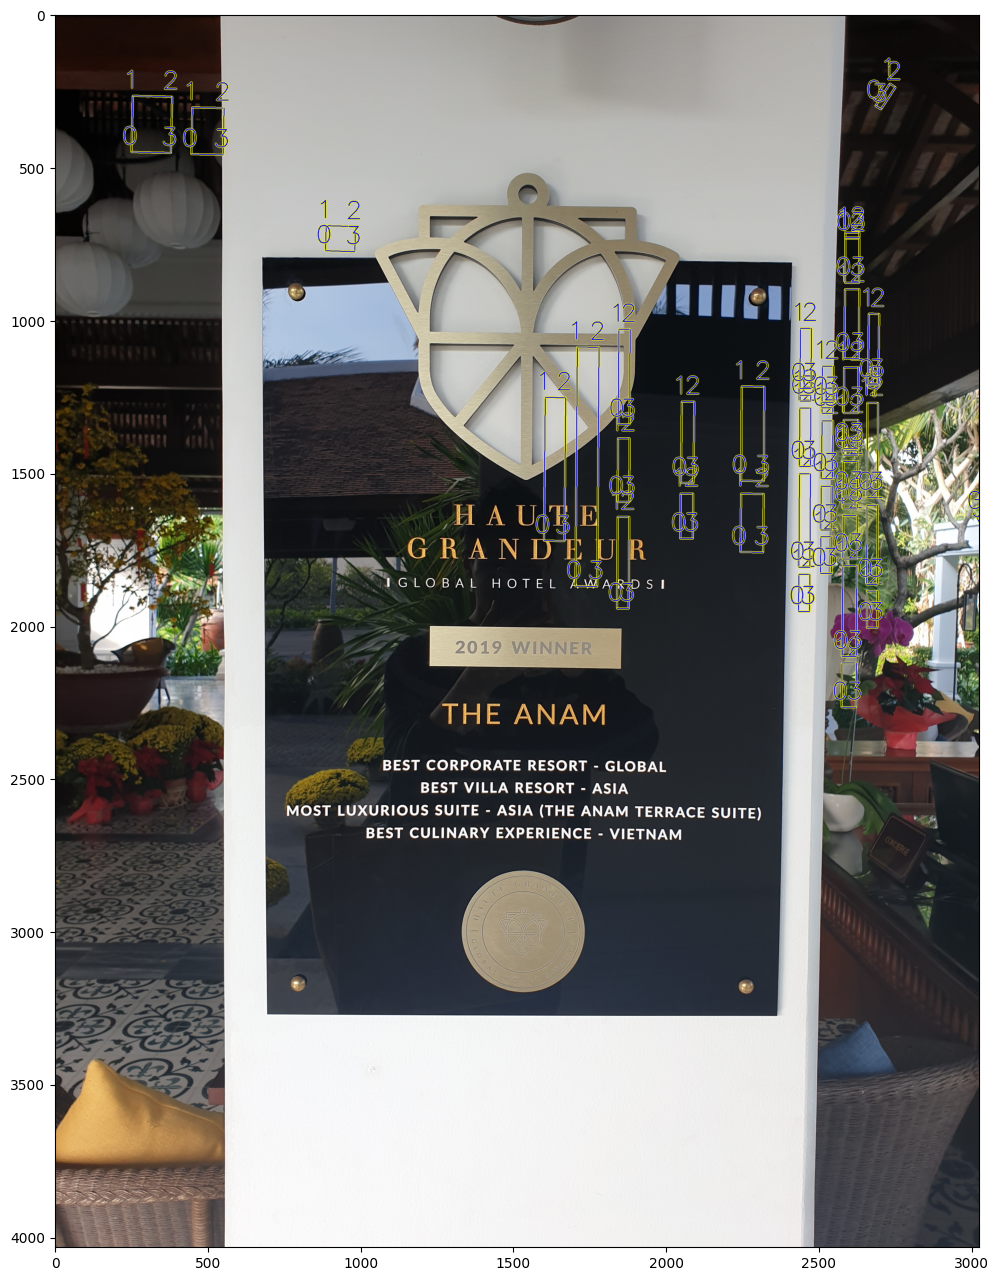

In [5]:
vis = image.copy()
draw_bboxes(vis, bboxes, double_lined=True, thickness=2, thickness_sub=5, write_point_numbers=True)

plt.figure(figsize=(16, 16))
plt.imshow(vis)

In [23]:
from PIL import Image, ImageOps

In [24]:
source = 'boostcamp'
file_name = '20200128_153714.jpg'

In [25]:
SOURCE_IMG_PATH = f"/opt/ml/input/data/{source}/images"
SOURCE_JSON_PATH = f"/opt/ml/input/data/{source}/ufo/random_split/val.json"

In [28]:
img = [cv2.imread(osp.join(SOURCE_IMG_PATH, file_name))[:, :, ::-1]]
print(img[0].shape)

(4032, 3024, 3)


In [29]:
img = [Image.open(osp.join(SOURCE_IMG_PATH, file_name))]
img = [ImageOps.exif_transpose(img[0])]
print(np.asarray(img[0]).shape)

(4032, 3024, 3)


In [ ]:
20181023_194810.jpg
20210915_124452.jpg
20210913_215831.jpeg
20191222_225910.jpg
20200124_121022.jpg
20200404_081417.jpg
1632025705925.jpg
1604828077798-1.jpg
20200115_185052.jpg
1632646840914-10.jpg
20210904_164313.jpg
20210910_163507.jpg
20201022_043911.jpg
20210915_183402.jpeg
20210610_141521.jpg
0210915_185505.jpeg
20200918_195633.jpg
0210830_231751.jpg
20201230_194246.jpg
20190828_210145.jpg
20210915_145042.jpeg
1632643837411-22.jpg
20200128_153714.jpg
20200210_211748.jpg
20210915_191844.jpeg
20210910_125221.jpg
1631619215373-0.jpg
20210915_191043.jpeg
20210915_150130.jpeg
20210913_004956.jpg
1632644162889-1.jpg
20210913_220603.jpeg
20210916_131546.jpeg
20210913_003516.jpg
20210813_060535.jpg
1632644162889-3.jpg
20190128_184639.jpg
20210915_124805.jpg
20210910_125742.jpg
20200715_112450.jpg
20210915_141119.jpeg
0210913_005631.jpg
20210915_124317.jpg
0210804_170542.jpg
1631619225806-2.jpg
0210914_125453.jpg
20210915_191103.jpeg
20210904_150715.jpg
20200330_233903.jpg
20210801_173814.jpg
20210914_122101.jpg
20210803_200120.jpg
20210908_125359.jpg
20210915_134710.jpg
20200110_143556.jpg
1632648252279-12.jpg
20181223_020606.jpg
20181117_002149.jpg
20210909_121614.jpg
1632025728267-1.jpg
0200902_162509.jpg
20180330_103134.jpg
20190608_214923.jpg
20210812_224753.jpg
20210915_192729.jpeg
20210913_003541.jpg
0210915_193433.jpeg
20210915_192836.jpeg
20210915_132123.jpg
1632025728267-2.jpg
20210913_010132.jpg
20190706_182948.jpg
20210904_174116.jpg
20210915_145004.jpeg
20210904_145044.jpg
1632646011372-4.jpg
20210913_005402.jpg
20210915_201632.jpg
20210910_125631.jpg
20210913_220429.jpeg
20210915_191128.jpeg
20210915_191742.jpeg
20201224_150405.jpg
20210913_005210.jpg
20210915_142034.jpeg
1632648807798.jpg
1632648216244.jpg
20200212_001737.jpg
20200203_153741.jpg
20210831_111241.jpg
20210819_144021.jpg
20210914_192248.jpeg
20191219_170225.jpg
20210913_003852.jpg
0190525_181912.jpg
20180330_103201.jpg
20201030_181144.jpg
20210913_002059.jpg
1632025691058-1.jpg
0180921_205435_001.jpg
20210115_170408.jpg
20210913_003240.jpg
20200113_162608.jpg
20210910_125055.jpg
1632025745030.jpg
0N8A5660.jpg
20210913_003432.jpg
20210913_004621.jpg
1632025691058-0.jpg
20210909_175403.jpg
1631619209578-11.jpg
20210914_091031.jpeg
20210911_181658.jpg
20210913_215256.jpeg
1632647191443-11.jpg
20210913_010858.jpg
20210915_191230.jpeg
20210915_190427.jpeg
20210916_175159.jpg
20200126_191740.jpg
20210913_210928.jpeg
20190818_212150.jpg
20200711_035400.jpg
20190714_174527.jpg
20181102_212737.jpg
20200630_214940.jpg
1632026039618.jpg
20210911_181550.jpg
1632646266774-1.jpg
20210306_213855.jpg
20210915_145432.jpeg
20210908_125458.jpg
1632652600619-6.jpg
1632025681410-1.jpg
20210911_134129.jpg
20200801_111854.jpg
20210915_145137.jpeg
20200116_203338.jpg
20210909_164347.jpg
20210914_193201.jpeg
20200126_194730.jpg
20210913_005155.jpg
20210916_200040.jpeg
20180728_142342.jpg
20210915_191023.jpeg
1632643837411-2.jpg
1632640391949-0.jpg
20210915_124216.jpg
20200916_001148.jpg
20210915_184616.jpeg
20210915_124823.jpg
1632640391949-4.jpg
20210403_165648.jpg
20201028_164519.jpg
20210914_194145.jpeg
20210915_191605.jpeg
20181109_205022.jpg
20210114_175917.jpg
20210913_220659.jpeg
20210909_173654.jpg
20200128_002515.jpg
20210914_075146.jpeg
20210908_131103.jpg
20210914_082714.jpeg
20210914_143248.jpeg
1632025861563.jpg
20200511_225637.jpg
1632652969768.jpg
20210911_181924.jpg
20210913_221353.jpeg
20210914_112147.jpeg
20210908_125333.jpg
20201222_170330.jpg
20201101_210445.jpg
20210915_124559.jpg
20210913_220021.jpeg
20201021_223733.jpg
20200806_205918.jpg
20210913_004845.jpg
20210914_193748.jpeg
1632650015287-11.jpg
1632026025926.jpg
1604828077798-0.jpg
1632647472971.jpg